In [1]:

%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks, butter, filtfilt
import numpy as np
#change plot size
plt.rcParams['figure.figsize'] = [10, 3]

data_dir = r"C:\Users\avido\Documents\other code\mike_accel_project\data\phyphox"

load data

In [2]:
folder = r"Acceleration without g 2025-09-01 10-14-23"
data_file = os.path.join(data_dir, folder, 'Raw Data.csv')
df = pd.read_csv(data_file)
df

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.003312,-0.542802,-0.130845,0.177206,0.585796
1,0.013332,-0.398454,-0.155289,0.102881,0.439846
2,0.023352,-0.187797,-0.217906,0.179624,0.339140
3,0.033372,-0.089049,-0.270247,0.236594,0.370054
4,0.043393,0.010768,-0.295644,0.188987,0.351052
...,...,...,...,...,...
959,9.612601,0.483527,-0.363822,0.696735,0.922824
960,9.622621,-0.130205,-0.367708,0.466334,0.607972
961,9.632641,-0.712340,-0.079973,0.082952,0.721599
962,9.642661,-0.270925,-0.664994,-0.118294,0.727744


Calculate samplerate

In [3]:
def calc_samplerate(df):
    start = df['Time (s)'].iloc[0]
    end = df['Time (s)'].iloc[-1]
    return len(df)/(end-start)

print(calc_samplerate(df))

99.90290125775331


Plot data

In [4]:
#dynamically get channel names, since sometimes they differ depending on settings

x_chan = [col for col in df.columns if 'x' in col][0]
y_chan = [col for col in df.columns if 'y' in col][0]
z_chan = [col for col in df.columns if 'z' in col][0]

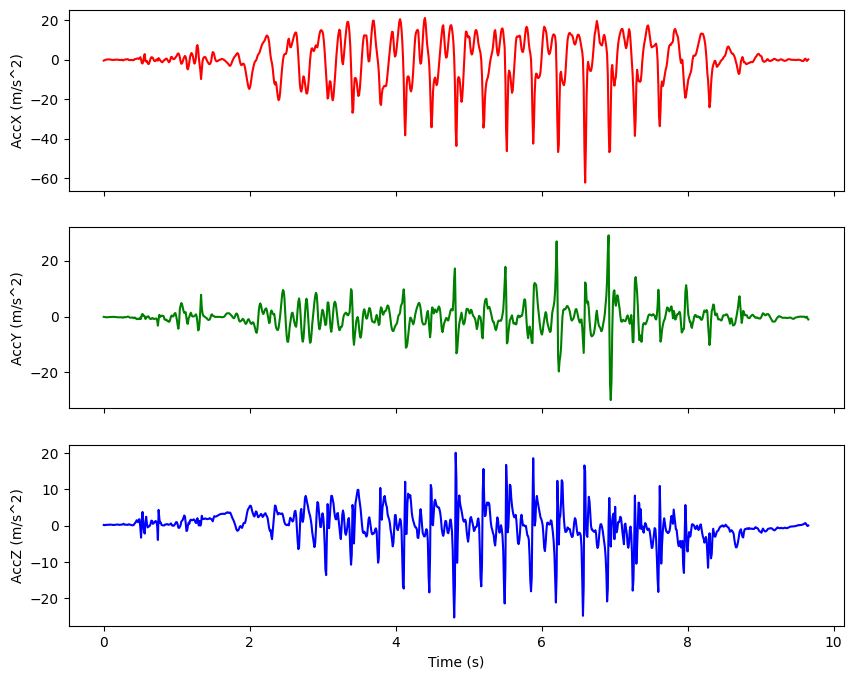

In [ ]:
# plot on 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(df['Time (s)'], df[x_chan], color='r')
axs[0].set_ylabel('AccX (m/s^2)')
axs[1].plot(df['Time (s)'], df[y_chan], color='g')
axs[1].set_ylabel('AccY (m/s^2)')
axs[2].plot(df['Time (s)'], df[z_chan], color='b')
axs[2].set_ylabel('AccZ (m/s^2)')
axs[2].set_xlabel('Time (s)')
plt.show()

Let's use Scipy's find_peaks() function to identify peaks in the signal.

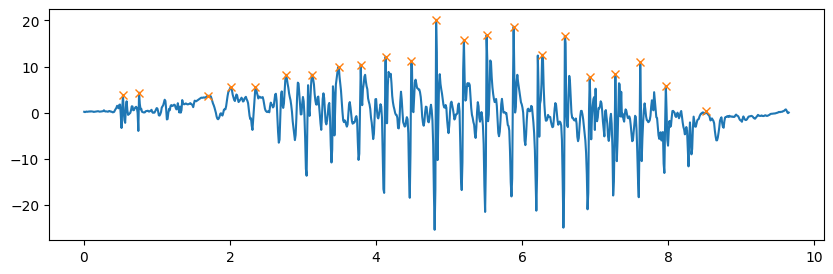

In [20]:
peaks, _ = find_peaks(df[z_chan], distance=20, prominence=4)

plt.plot(df['Time (s)'], df[z_chan])
plt.plot(df['Time (s)'].iloc[peaks], df[z_chan].iloc[peaks], 'x')

we can also flip the signal to find the negative peaks, then use the combination to be more robust.

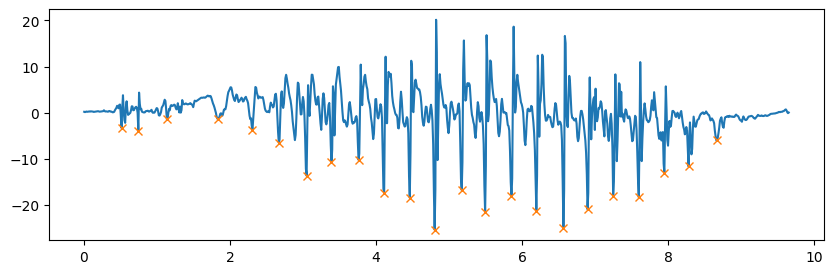

In [7]:
peaks, _ = find_peaks(-1*df[z_chan], distance=20, prominence=4)

plt.plot(df['Time (s)'], df[z_chan])
plt.plot(df['Time (s)'].iloc[peaks], df[z_chan].iloc[peaks], 'x')

Let's try filtering the signal

In [22]:
def standardize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def remove_outliers(signal, thresh = 3):
    return signal[np.abs(signal - np.mean(signal)) < thresh * np.std(signal)]

def butterworth_filter(signal, cutoff, fs, order=4):
    '''"Biometrics Analysis V.1"
    Apply a Butterworth low-pass filter to the signal.
    Parameters:
    signal : array-like
        The input signal to be filtered.
    cutoff : float
        The cutoff frequency of the filter, in Hz.
    fs : float
        The sampling frequency of the signal.
    order : int, optional
        The order of the filter. Default is 4.
    Returns:
    array-like
        The filtered signal.
    '''
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, signal)
    return y

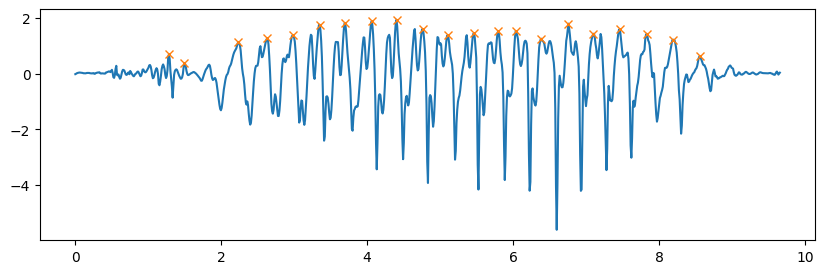

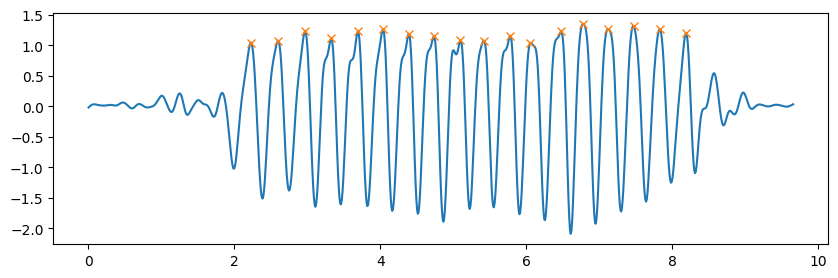

In [23]:
raw = standardize(df[x_chan])
peaks_raw, _ = find_peaks(raw, distance=20, prominence=1)
plt.plot(df['Time (s)'], raw)
plt.plot(df['Time (s)'].iloc[peaks_raw], raw[peaks_raw], 'x')
plt.show()

filtered = butterworth_filter(raw, cutoff=6, fs=calc_samplerate(df), order=4)
peaks, _ = find_peaks(filtered, distance=20, prominence=1)
plt.plot(df['Time (s)'], filtered)
plt.plot(df['Time (s)'].iloc[peaks], filtered[peaks], 'x')
plt.show()

in the above, notice how in the unfiltered data there is a "double peak" that is inconsitently detected (sometimes the first peak, sometimes the second). After filtering, this is more stable.

Next let's try using removing/inserting peaks based on the median peak distance

In [24]:
def clean_peaks(peaks, tolerance_factor=2):
    # Iterate through peaks. If interpeak interval is close to median, keep both peaks. 
    # If its close to 2x median, insert a peak in between.
    # else, discard.
    median_peak_distance = np.median(np.diff(peaks))
    tolerance = tolerance_factor * median_peak_distance * np.std(np.diff(peaks)) / np.mean(np.diff(peaks))
    cleaned_peaks = []
    i = 0
    while i < len(peaks) - 1:
        interval = peaks[i+1] - peaks[i]
        if np.isclose(interval, median_peak_distance, atol=tolerance):
            cleaned_peaks.append(peaks[i])
            i += 1
        elif np.isclose(interval, 2*median_peak_distance, atol=2*tolerance):
            cleaned_peaks.append(peaks[i])
            # Insert a peak in between
            mid_peak = (peaks[i] + peaks[i+1]) // 2
            cleaned_peaks.append(mid_peak)
            i += 1
        else:
            i += 1
    # Append the last peak if it wasn't added
    if i == len(peaks) - 1:
        cleaned_peaks.append(peaks[-1])
    return np.array(cleaned_peaks)

def reverse_peaks(peaks, len_signal):
    return (len_signal - peaks)[::-1]

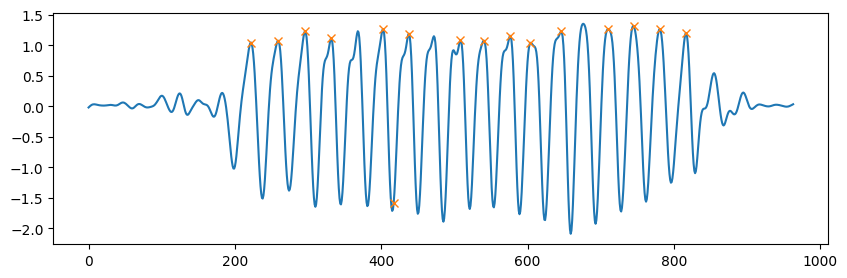

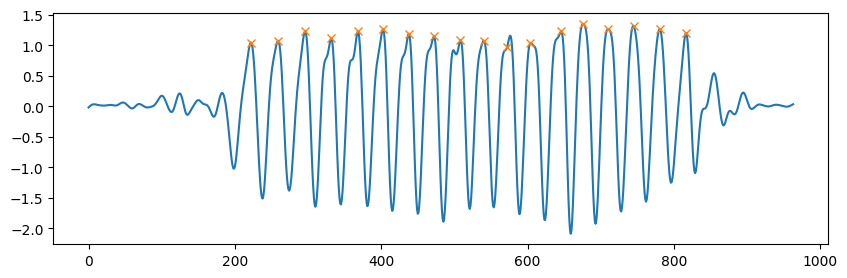

In [30]:
raw = standardize(df[x_chan])
filtered = butterworth_filter(raw, cutoff=6, fs=calc_samplerate(df), order=4)
peaks, _ = find_peaks(filtered, distance=20, prominence=1)

# pretend we missed one and had an extra
missing_peaks = list(peaks)
missing_peaks.pop(4)
missing_peaks.pop(6)
missing_peaks.pop(11)
missing_peaks.append(missing_peaks[4] + 15)  # add an extra peak
missing_peaks = sorted(missing_peaks)
plt.plot(filtered)
plt.plot(missing_peaks, filtered[missing_peaks], 'x')
plt.show()

# run the cleaning function backwards and forwards to catch both extra and missing peaks
cleaned_peaks = clean_peaks(peaks)
cleaned_peaks = reverse_peaks(clean_peaks(reverse_peaks(cleaned_peaks, len(filtered))), len(filtered))

plt.plot(filtered)
plt.plot(cleaned_peaks, filtered[cleaned_peaks], 'x')

plt.show()

Next steps: Run step counting algorithm on both positive and negative, across all channels, for added robustness